In [ ]:
# !git clone https://github.com/pytorch/fairseq
!pip install s3prl

In [ ]:
!pip install "dask[complete]"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
evalAudioPath = "/content/drive/MyDrive/assigments/vox1/wav/"
evalCsvPath = "/content/drive/MyDrive/assigments/VoxCeleb-Trial-Cleaned.txt"
modelPath = "/content/drive/MyDrive/assigments/models/"
trainData = "/content/drive/MyDrive/assigments/vox2/aac/"
basePath = "/content/drive/MyDrive/assigments/"
mixturePath = "/content/drive/MyDrive/assigments/vox2/mixtures/"
trainCsvPath = basePath+'Train.csv'
testCsvPath = basePath+'Test.csv'
beforeFTSim = basePath + "SimilarityBeforeFT.pkl"
afterFTSim = basePath + "SimilarityAfterFT.pkl"
beforeEmb = basePath + "EmbBeforeFT.pkl"
afterEmb = basePath + "EmbAfterFT.pkl"
beforeDf = basePath + "beforeDF.pkl"

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/assigments/vox1/vox1_test_wav.zip" -d "/content/drive/MyDrive/assigments/vox1/"

In [4]:
import torch
import torchaudio
import torch.nn.functional as F
# from s3prl.hub import wavlm_base_plus
import pandas as pd
import os
import csv
import json
import math
import pickle
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
import numpy as np
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments
# from transformers import a
# from s3prl.downstream.sv_voxceleb1.expert import DownstreamExpert

In [ ]:
dirLst = []#[os.path.join(trainData,root,dir) for root, dirs, files in os.walk(trainData) for dir in dirs if root == trainData]
for root, dirs, files in os.walk(trainData):
  if root == trainData:
    for dir in dirs:
      dirLst.append(os.path.join(trainData,root,dir))
  else:
    break

dirLst.sort()
testDir = dirLst[-18:]
trainDir = dirLst[:len(dirLst)-18]
run = False
if run:
  with open(trainCsvPath, 'w', newline='') as file1:
      writer = csv.writer(file1)
      for idx, fld in enumerate(trainDir):
        for root, dirs, files in os.walk(fld):
          if os.path.basename(root) == os.path.basename(fld):
            continue
          folderNm = os.path.basename(root)
          for f in files:
            filepth = os.path.join(fld,folderNm,f)
            id = os.path.basename(fld)
            dataLst = [filepth, id, idx]
            writer.writerow(dataLst)

  with open(testCsvPath, 'w', newline='') as file2:
      writer = csv.writer(file2)
      for idx, fld in enumerate(testDir):
        for root, dirs, files in os.walk(fld):
          if os.path.basename(root) == os.path.basename(fld):
            continue
          folderNm = os.path.basename(root)
          for f in files:
            filepth = os.path.join(fld,folderNm,f)
            id = os.path.basename(fld)
            dataLst = [filepth, id, idx]
            writer.writerow(dataLst)
  #  break
print(len(dirLst))
print(len(trainDir))
print(len(testDir))

118
100
18


In [ ]:
df = pd.read_csv(evalCsvPath, delimiter=" ", names=["match", "wav1", "wav2"])

In [ ]:
model = wavlm_base_plus().to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


UpstreamExpert(
  (model): WavLM(
    (feature_extractor): ConvFeatureExtractionModel(
      (conv_layers): ModuleList(
        (0): Sequential(
          (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
          (3): GELU(approximate='none')
        )
        (1-4): 4 x Sequential(
          (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): GELU(approximate='none')
        )
        (5-6): 2 x Sequential(
          (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): GELU(approximate='none')
        )
      )
    )
    (post_extract_proj): Linear(in_features=512, out_features=768, bias=True)
    (dropout_input): Dropout(p=0.1, inplace=False)
    (dropout_features): Dropout(p=0.1, inplace=False)
    (encoder): Transform

In [ ]:
import gc

def processAudio(filepath, sample_rate = 16000):
  wav, sr = torchaudio.load(filepath)
  wav = wav.to("cuda" if torch.cuda.is_available() else "cpu")
  if sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sample_rate)
        wav = resampler(wav)

  return wav

def getEmbedding(audioWav):
  emb = model(audioWav)['last_hidden_state'].mean(dim=1)
  return emb

def getSimilarityScore(fp1, fp2, dct):
  if fp1 in dct:
    emb1 = torch.from_numpy(dct[fp1])
  else:
    print(f"inside wrong condition - {fp1}")
    wav1 = processAudio(evalAudioPath+fp1)
    emb1 = getEmbedding(wav1)
    emb1.detach()
    del wav1
    dct[fp1] = emb1

  if fp2 in dct:
    emb2 = torch.from_numpy(dct[fp2])
  else:
    print(f"inside wrong condition - {fp1}")
    wav2 = processAudio(evalAudioPath+fp2)
    emb2 = getEmbedding(wav2)
    emb2.detach()
    del wav2
    dct[fp2] = emb2

  rval = F.cosine_similarity(emb1, emb2).cpu().detach().numpy()[0]
  del emb1
  del emb2
  gc.collect()
  return rval

def applyThreshold(value, threshold = 0.90):
  if value > threshold:
    return 1
  else:
    return 0

def getSpeakerSimilartyScore(df, chkPt):
  if os.path.exists(beforeFTSim):
    with open(beforeFTSim, 'rb') as f1:
      prevRun = pickle.load(f1)
      # prevRun = json.loads(f1)
  else:
    prevRun = {}


  if os.path.exists(beforeEmb):
    with open(beforeEmb, 'rb') as f2:
      embBuf = pickle.load(f2)
      # embBuf = json.loads(f2)
  else:
    embBuf = {}

  # prevRun.detach()
  # embBuf.detach()

  cnt = 0
  for i in range(0, len(df), 100):
    batch_df = df.iloc[i:i + 100]
    for row in df.itertuples():
      cnt += 1
      if (row.wav1, row.wav2) in prevRun:
        simscore = prevRun[(row.wav1, row.wav2)]
      else:
        simscore = getSimilarityScore(row.wav1, row.wav2, embBuf)
        prevRun[(row.wav1, row.wav2)] = simscore

      if cnt == chkPt:
        with open(beforeFTSim, 'wb') as f1:
          pickle.dump(prevRun, f1, protocol=pickle.HIGHEST_PROTOCOL)
          # json.dump(prevRun, f1)
        with open(beforeEmb, 'wb') as f2:
          pickle.dump(embBuf, f2, protocol=pickle.HIGHEST_PROTOCOL)
          # json.dump(embBuf, f2)
        print("Data Stored")
        cnt = 0
    torch.cuda.empty_cache()
    gc.collect()

  with open(beforeFTSim, 'wb') as f1:
    pickle.dump(prevRun, f1, protocol=pickle.HIGHEST_PROTOCOL)
  with open(beforeEmb, 'wb') as f2:
    pickle.dump(embBuf, f2, protocol=pickle.HIGHEST_PROTOCOL)
    # json.dump(embBuf, f2)

  df["score"] = df.apply(lambda row: prevRun[(row['wav1'], row['wav2'])], axis=1)
  # df["score"] = df.apply(lambda row: getSimilarityScore(model, evalAudioPath+row['wav1'], evalAudioPath+row['wav2']), axis=1)
  df['pred'] = df.apply(lambda row: applyThreshold(row['score']), axis=1)

# def compute_speaker_id_accuracy(df, yTrue='match', ypred = 'pred'):
#   totalCount = len(df.index)
#   trueCount = (df[yTrue] == df[ypred]).values.sum()
#   return (trueCount/totalCount)*100

def compute_identification_accuracy(labels, scores, threshold=0.5):
    predictions = [1 if score >= threshold else 0 for score in scores]
    correct = sum(1 for pred, label in zip(predictions, labels) if pred == label)
    accuracy = correct / len(labels) * 100  # Convert to percentage
    return accuracy

def compute_eer(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    eer = interp1d(fpr, fnr)(eer_threshold)
    return eer * 100

def compute_tar_at_far(labels, scores, target_far=0.01):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    tar_at_far = interp1d(fpr, tpr)(target_far)
    return tar_at_far * 100

In [ ]:
l = list(df['wav1'].unique()) + list(df['wav2'].unique())
l = list(set(l))
tmpDf = pd.DataFrame(l)

In [ ]:
run = False
if run:
  embBuf = {}
  countBatch = 0
  for i in range(0, len(l), 100):
    batchLst = l[i:i + 100]
    countBatch += 1
    for fp in batchLst:
      wav = processAudio(evalAudioPath+fp)
      emb = model(wav)['last_hidden_state'].mean(dim=1)
      embBuf[fp] = emb.cpu().detach().numpy()
    torch.cuda.empty_cache()
    gc.collect()
    with open(beforeEmb, 'wb') as f2:
      pickle.dump(embBuf, f2, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Batch Number {countBatch} completed - Out of {math.ceil(len(l)/100)} ")

  with open(beforeEmb, 'wb') as f2:
    pickle.dump(embBuf, f2, protocol=pickle.HIGHEST_PROTOCOL)


Batch Number 1 completed - Out of 48 
Batch Number 2 completed - Out of 48 
Batch Number 3 completed - Out of 48 
Batch Number 4 completed - Out of 48 
Batch Number 5 completed - Out of 48 
Batch Number 6 completed - Out of 48 
Batch Number 7 completed - Out of 48 
Batch Number 8 completed - Out of 48 
Batch Number 9 completed - Out of 48 
Batch Number 10 completed - Out of 48 
Batch Number 11 completed - Out of 48 
Batch Number 12 completed - Out of 48 
Batch Number 13 completed - Out of 48 
Batch Number 14 completed - Out of 48 
Batch Number 15 completed - Out of 48 
Batch Number 16 completed - Out of 48 
Batch Number 17 completed - Out of 48 
Batch Number 18 completed - Out of 48 
Batch Number 19 completed - Out of 48 
Batch Number 20 completed - Out of 48 
Batch Number 21 completed - Out of 48 
Batch Number 22 completed - Out of 48 
Batch Number 23 completed - Out of 48 
Batch Number 24 completed - Out of 48 
Batch Number 25 completed - Out of 48 
Batch Number 26 completed - Out of

In [ ]:
import dask.dataframe as dd
from dask.multiprocessing import get
# tdf = df.head()
# print(tdf)
print(f"length of Dataframe is {len(df)}")
ddata = dd.from_pandas(df, npartitions=100)
def myfunc(row):
  print(f"{row.name} is being processed")
  with open(beforeEmb, 'rb') as f2:
    embBuf = pickle.load(f2)
  return getSimilarityScore(row['wav1'], row['wav2'], embBuf)


# print(list(ddata['wav1']))
df["score"] = ddata.apply((lambda row: myfunc(row)), axis=1, meta=(None, 'float64')).compute(scheduler='threads')
# ddata.map_partitions(lambda df: df.apply((lambda row: myfunc(row)), axis=1)).compute()
# df["score"] = df.apply(lambda row: getSimilarityScore(row['wav1'], row['wav2'], embBuf), axis=1)

Streaming output truncated to the last 5000 lines.
7666 is being processed
887 is being processed
7667 is being processed
7668 is being processed
888 is being processed
889 is being processed
7669 is being processed
7670 is being processed
890 is being processed
891 is being processed
7671 is being processed
892 is being processed
7672 is being processed
7673 is being processed893 is being processed

894 is being processed
7674 is being processed
7675 is being processed
895 is being processed
7676 is being processed
896 is being processed
7677 is being processed
897 is being processed
7678 is being processed
898 is being processed
899 is being processed
7679 is being processed
900 is being processed
7680 is being processed
7681 is being processed
901 is being processed
7682 is being processed
902 is being processed
7683 is being processed903 is being processed

904 is being processed
7684 is being processed
905 is being processed
7685 is being processed
7686 is being processed
906 is b

In [ ]:
df.to_pickle(beforeDf)

In [ ]:
compute_identification_accuracy(tdf['match'],tdf['pred'])

60.0

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_dim, num_classes, margin=0.5, scale=64.0):
        super(ArcFaceLoss, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight_norm = F.normalize(self.weight, p=2, dim=1)

        # Compute cosine similarity
        cosine = torch.matmul(embeddings, weight_norm.T)

        # Convert cosine similarity to angle and apply margin
        theta = torch.acos(torch.clamp(cosine, -1.0, 1.0))
        theta_margin = theta + self.margin
        cosine_margin = torch.cos(theta_margin)

        # Create one-hot encoded labels
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Apply ArcFace modification
        logits = one_hot * cosine_margin + (1.0 - one_hot) * cosine
        logits *= self.scale  # Apply feature scaling

        return F.cross_entropy(logits, labels)  # Compute loss

In [ ]:
class AudioFolder(Dataset):
  def __init__(self, filePath, max_length=48000):
    df = pd.read_csv(filePath, names=['file_path', 'id', 'label'])
    self.filePaths = df
    self.max_length = max_length

  def __len__(self):
    return len(self.filePaths)

  def processAudio(filepath, sample_rate = 16000):
    print("***************")
    print(filepath)
    wav, sr = torchaudio.load(filepath)
    wav = wav.to("cuda" if torch.cuda.is_available() else "cpu")
    if sample_rate != sample_rate:
          resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sample_rate)
          wav = resampler(wav)

    return wav

  def __getitem__(self, idx):
      file_path = self.filePaths.iloc[idx, 0]
      speaker_id = self.filePaths.iloc[idx, 1]
      label = self.filePaths.iloc[idx, 2]
      waveform, sample_rate = torchaudio.load(file_path)
      if sample_rate != 16000:
          waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
      waveform = waveform.squeeze(0)
      # waveform = self.processAudio(file_path)

      if self.max_length:
        if waveform.size(0) > self.max_length:
            waveform = waveform[:self.max_length]
        elif waveform.size(0) < self.max_length:
            padding = torch.zeros(self.max_length - waveform.size(0))
            waveform = torch.cat([waveform, padding])

      return waveform, label


In [ ]:
df_td = pd.read_csv(trainCsvPath, names=['file_path', 'id', 'label'])
file_path = df_td.iloc[0, 0]
# speaker_id = df_td.loc[idx]['id']
# label = df_td.loc[idx]['label']

In [ ]:
#Lets Fine Tune the model

lora_config = LoraConfig(
    #task_type=TaskType.FEATURE_EXTRACTION,  # Speaker verification needs embeddings
    r=32,  # Low-rank adaptation rank
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,
    target_modules= ["q_proj", "v_proj"]  # Apply LoRA to attention layers
)
model = get_peft_model(model, lora_config)
model.train()

PeftModel(
  (base_model): LoraModel(
    (model): UpstreamExpert(
      (model): WavLM(
        (feature_extractor): ConvFeatureExtractionModel(
          (conv_layers): ModuleList(
            (0): Sequential(
              (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
              (3): GELU(approximate='none')
            )
            (1-4): 4 x Sequential(
              (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): GELU(approximate='none')
            )
            (5-6): 2 x Sequential(
              (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): GELU(approximate='none')
            )
          )
        )
        (post_extract_proj): Linear(in_features=512, out_features=768, b

In [ ]:
train_data = AudioFolder(trainCsvPath)
test_data = AudioFolder(testCsvPath)
batch_size = 32
# subsets = list(range(0, len(train_data), 3))
# train_data = torch.utils.data.Subset(train_data, subsets)
train_dataloader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=64,shuffle=False)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
arcface_loss = ArcFaceLoss(embedding_dim=768, num_classes=len(trainDir)).to(device)

for epoch in range(2):
    total_loss = 0
    for waveforms, labels in tqdm(train_dataloader):

        # inputs = feature_extractor(waveforms.tolist(), sampling_rate=16000, return_tensors="pt", padding=True)
        # input_values = inputs["input_values"].to(device)
        waveforms = waveforms.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(waveforms)
        # print(outputs.keys())
        outputs = outputs['last_hidden_state'].mean(dim=1)
        # labels = torch.tensor([id_to_idx[sid] for sid in speaker_ids], dtype=torch.long).to(device)
        loss = arcface_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

    model.save_pretrained(modelPath)

# torch.save(model.state_dict(), "saved_model/full_model.pth")

# model.eval()

  0%|          | 0/933 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 933/933 [1:44:44<00:00,  6.74s/it]


Epoch 1, Average Loss: 37.3395


100%|██████████| 933/933 [10:15<00:00,  1.52it/s]

Epoch 2, Average Loss: 37.3420


In [ ]:
base_model = wavlm_base_plus().to("cuda" if torch.cuda.is_available() else "cpu")
lora_model = PeftModel.from_pretrained(base_model, modelPath)
lora_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): UpstreamExpert(
      (model): WavLM(
        (feature_extractor): ConvFeatureExtractionModel(
          (conv_layers): ModuleList(
            (0): Sequential(
              (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
              (3): GELU(approximate='none')
            )
            (1-4): 4 x Sequential(
              (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): GELU(approximate='none')
            )
            (5-6): 2 x Sequential(
              (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): GELU(approximate='none')
            )
          )
        )
        (post_extract_proj): Linear(in_features=512, out_features=768, b

In [ ]:
def getEmbeddingOptimized(row):
  fp = row.iloc[0]
  wav = processAudio(evalAudioPath+fp)
  try:
    out = lora_model(wav)
    emb = out['last_hidden_state'].mean(dim=1)
    emb = emb.cpu().detach().numpy()
  except Exception as e:
    print(f"There has been an exception for File - {fp} - Defaulting Embedding")
    print(e)
    emb = np.zeros((1,768))
  torch.cuda.empty_cache()
  gc.collect()
  return emb

ddf = dd.from_pandas(tmpDf, npartitions=30)

# print(list(ddata['wav1']))
tmpDf["embeddings"] = ddf.apply((lambda row: getEmbeddingOptimized(row)), axis=1, meta=(None, 'float64')).compute(scheduler='threads')
embBufNew = dict(zip(tmpDf[0], tmpDf['embeddings']))
with open(afterEmb, 'wb') as f2:
  pickle.dump(embBufNew, f2, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


There has been an exception for File - id10273/ZpPPaMazpf0/00001.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10294/L812MIi7ruk/00012.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10270/8jEAjG6SegY/00015.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10292/azw51ZGuz9k/00012.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10273/eLl_yTeuaKo/00004.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10282/U3xR3MZjEVg/00002.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10300/8EDKH42GZ1o/00024.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10300/Fi8lnFPYgII/00014.wav - Defaulting Embedding
'last_hidden_state'
There has been an exception for File - id10284/7yx9A0yzLYk/00021.wav - Defaulting Embedding
'last_hidden

In [ ]:
with open(beforeDf, 'rb') as input:
  df = pickle.load(input)

<ipython-input-7-8657aaf16ecc>:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(input)


In [ ]:
# tdf2.loc[(tdf2['score2'] < 0.6)]
print(tdf1['score'].mean())
print(tdf1['score2'].mean())
print(tdf2['score'].mean())
print(tdf2['score2'].mean())

0.8525323
0.8466648140686782
0.87825686
0.8700487604162622


In [ ]:
acc =  compute_identification_accuracy(df['match'], df['score'], threshold=0.85)
eer = compute_eer(df['match'], df['score'])
tar_at_far = compute_tar_at_far(df['match'], df['score'], target_far=0.01)

print(f"Accuracy : {acc}, EER : {eer}, TAR : {tar_at_far}")

acc =  compute_identification_accuracy(df['match'], df['score2'], threshold=0.8782)
eer = compute_eer(df['match'], df['score2'])
tar_at_far = compute_tar_at_far(df['match'], df['score2'], target_far=0.01)

print(f"Accuracy : {acc}, EER : {eer}, TAR : {tar_at_far}")

Accuracy : 60.69950451763334, EER : 36.7852975495916, TAR : 7.584597432905485
Accuracy : 61.9236374234917, EER : 38.16219369894982, TAR : 7.158693115519253


<ipython-input-19-23b1627aa4f2>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([tdf1['score'], tdf1['score2']], vert = True, showmeans=True, showfliers=True, patch_artist=True, labels=["Pre-Tuning", "Post-Tuning"])
<ipython-input-19-23b1627aa4f2>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([tdf2['score'], tdf2['score2']], vert = True, showmeans=True, showfliers=True, patch_artist=True, labels=["Pre-Tuning", "Post-Tuning"])


Text(0.5, 1.0, 'Matched')

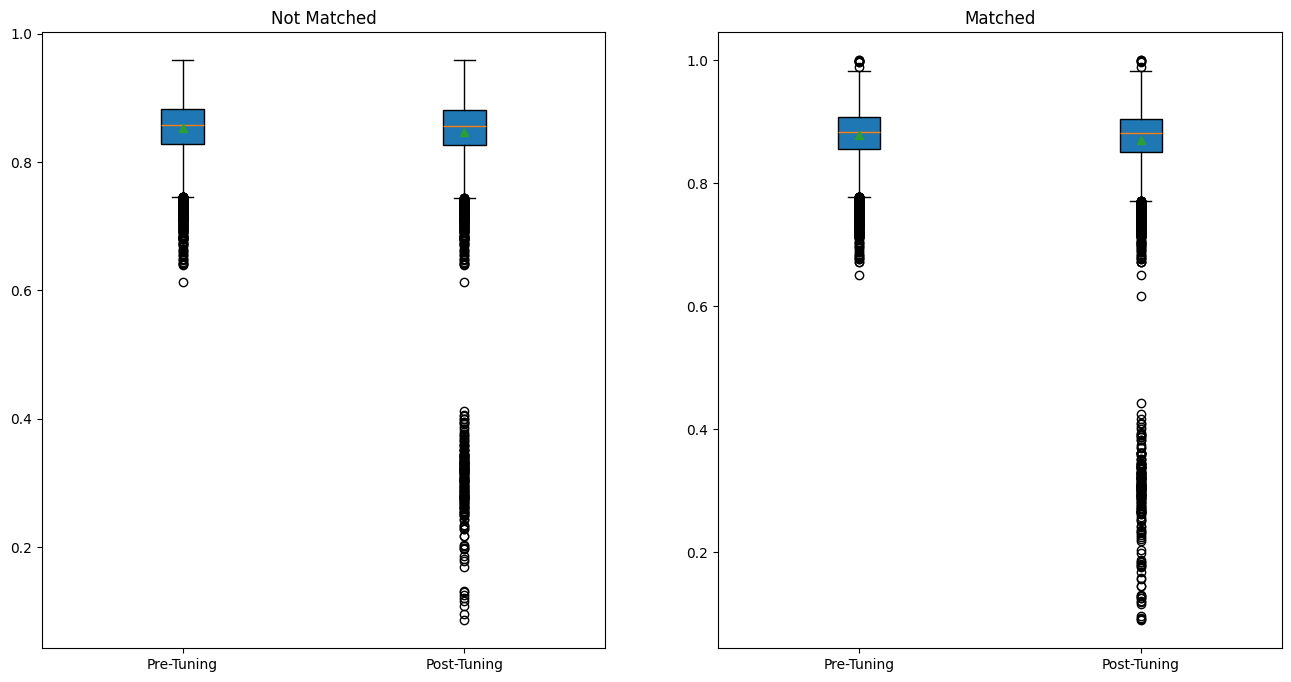

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16,8)
tdf1 = df.loc[df['match'] == 0]
tdf2 = df.loc[df['match'] == 1]
axs[0].boxplot([tdf1['score'], tdf1['score2']], vert = True, showmeans=True, showfliers=True, patch_artist=True, labels=["Pre-Tuning", "Post-Tuning"])
axs[0].set_title("Not Matched")
axs[1].boxplot([tdf2['score'], tdf2['score2']], vert = True, showmeans=True, showfliers=True, patch_artist=True, labels=["Pre-Tuning", "Post-Tuning"])
axs[1].set_title("Matched")

In [ ]:
import dask.dataframe as dd
from dask.multiprocessing import get
# tdf = df.head()
# print(tdf)
ddata = dd.from_pandas(df, npartitions=30)
# ddata = ddata.persist()
with open(afterEmb, 'rb') as f2:
  embBuf = pickle.load(f2)

def myfunc(row, embBuf=embBuf):
  return getSimilarityScore(row['wav1'], row['wav2'], embBuf)


# print(list(ddata['wav1']))
df["score2"] = ddata.apply((lambda row: myfunc(row)), axis=1, meta=(None, 'float64')).compute(scheduler='processes')
df.to_pickle(beforeDf)

In [ ]:
wav1 = processAudio(evalAudioPath+'id10276/5YncBThNd5E/00005.wav')
out = lora_model(wav1)
rs = out['last_hidden_state'].mean(dim=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
!pip install speechbrain
!pip install mir_eval
!pip install pesq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
trainCsvPath = basePath+'TrainSep.csv'
testCsvPath = basePath+'TestSep.csv'
sepModelPath = basePath + "SepModel/"
extractedClip1Path = mixturePath + "extracted/"

In [ ]:
dirLst = []#[os.path.join(trainData,root,dir) for root, dirs, files in os.walk(trainData) for dir in dirs if root == trainData]
for root, dirs, files in os.walk(trainData):
  if root == trainData:
    for dir in dirs:
      dirLst.append(os.path.join(trainData,root,dir))
  else:
    break

dirLst.sort()
testDir = dirLst[50:100]
trainDir = dirLst[:50]

sample1 = []
sample2 = []
run = False
if run:
  with open(trainCsvPath, 'w', newline='') as file1:
      writer = csv.writer(file1)
      for idx, fld in enumerate(trainDir):
        for root, dirs, files in os.walk(fld):
          if os.path.basename(root) == os.path.basename(fld):
            continue
          folderNm = os.path.basename(root)
          for f in files:
            filepth = os.path.join(fld,folderNm,f)
            id = os.path.basename(fld)
            dataLst = [filepth, id, idx]
            writer.writerow(dataLst)

  with open(testCsvPath, 'w', newline='') as file2:
      writer = csv.writer(file2)
      for idx, fld in enumerate(testDir):
        for root, dirs, files in os.walk(fld):
          if os.path.basename(root) == os.path.basename(fld):
            continue
          folderNm = os.path.basename(root)
          for f in files:
            filepth = os.path.join(fld,folderNm,f)
            id = os.path.basename(fld)
            dataLst = [filepth, id, idx]
            writer.writerow(dataLst)
  #  break
print(len(dirLst))
print(len(trainDir))
print(len(testDir))

118
50
50


In [ ]:
df2 = pd.read_csv(trainCsvPath, names=["path", "id", "indx"])
idDct = dict(zip(df2["id"], df2["path"]))

In [ ]:
import random

def create_random_pairs(idPathDict, num_pairs):
  pairs = []
  # count = 0
  keyLst = list(idPathDict.keys())
  print(keyLst)
  print(type(keyLst))
  for _ in range(num_pairs):
    pair = random.sample(keyLst, 2)
    pairs.append((idPathDict[pair[0]], idPathDict[pair[1]]))
  return pairs

# Create 100 random pairs from trainDir
random_pairs = create_random_pairs(idDct, 100)

# Print the pairs (optional)
for pair in random_pairs:
  print(pair)

['id00017', 'id00061', 'id00081', 'id00154', 'id00419', 'id00562', 'id00812', 'id00817', 'id00866', 'id00926', 'id01000', 'id01041', 'id01066', 'id01106', 'id01224', 'id01228', 'id01298', 'id01333', 'id01437', 'id01460', 'id01509', 'id01541', 'id01567', 'id01593', 'id01618', 'id01822', 'id01892', 'id01989', 'id02019', 'id02057', 'id02086', 'id02181', 'id02286', 'id02317', 'id02445', 'id02465', 'id02542', 'id02548', 'id02576', 'id02577', 'id02685', 'id02725', 'id02745', 'id03030', 'id03041', 'id03127', 'id03178', 'id03347', 'id03382', 'id03524']
<class 'list'>
('/content/drive/MyDrive/assigments/vox2/aac/id02181/02gIO4WrZLY/00001.m4a', '/content/drive/MyDrive/assigments/vox2/aac/id03347/YdoK1gucOng/00212.m4a')
('/content/drive/MyDrive/assigments/vox2/aac/id01298/P0o-9sIjdyE/00180.m4a', '/content/drive/MyDrive/assigments/vox2/aac/id03524/CDqYVxpilaU/00037.m4a')
('/content/drive/MyDrive/assigments/vox2/aac/id02057/ycaPt-w1JMc/00424.m4a', '/content/drive/MyDrive/assigments/vox2/aac/id02548

In [ ]:
import random
import librosa
import soundfile as sf
import numpy as np

def processAudio(filepath, sample_rate = 16000):
  wav, sr = torchaudio.load(filepath)
  wav = wav.to("cuda" if torch.cuda.is_available() else "cpu")
  if sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sample_rate)
        wav = resampler(wav)

  return wav

def mix_audio_clips(clip1_path, clip2_path, max_len = 48000, output_path = mixturePath):
    # try:
    wav1 = processAudio(clip1_path).squeeze(0)
    wav2 = processAudio(clip2_path).squeeze(0)

    # print(wav1.shape, wav2.shape)

    if wav1.size(0) > max_len:
      wav1 = wav1[:max_len]
    elif wav1.size(0) < max_len:
        wav1 = torch.cat([wav1, torch.zeros(max_len - wav1.size(0))])

    if wav2.size(0) > max_len:
        wav2 = wav2[:max_len]
    elif wav2.size(0) < max_len:
        wav2 = torch.cat([wav2, torch.zeros(max_len - wav2.size(0))])

    mixed_audio = wav1 + wav2
    mixed_audio = mixed_audio/torch.max(torch.abs(mixed_audio))
    id1 = clip1_path.split("/")[-3]
    id2 = clip2_path.split("/")[-3]
    fname = f"mix_{id1}_{id2}.wav"
    fmixPath = output_path+fname
    newClip1Path = output_path+"orig1/"+id1+".wav"
    newClip2Path = output_path+"orig2/"+id2+".wav"
    sf.write(fmixPath, mixed_audio.cpu().numpy(), 16000)
    sf.write(newClip1Path, wav1.cpu().numpy(), 16000)
    sf.write(newClip2Path, wav2.cpu().numpy(), 16000)


    return {'m':fmixPath, 'f1':newClip1Path, 'f2':newClip2Path}




In [ ]:
from speechbrain.pretrained import SepformerSeparation as ss
sepModel = ss.from_hparams(source="speechbrain/sepformer-wham", savedir=sepModelPath)

In [ ]:
run = False
if run:
  mixLst = []
  count = 1
  for fp1, fp2 in random_pairs:
    print(f"Writing File {count}")
    count += 1
    mixLst.append(mix_audio_clips(fp1, fp2))

  with open(basePath+"mixList.jsn", 'wb') as fh1:
    pickle.dump(mixLst, fh1, protocol=pickle.HIGHEST_PROTOCOL)


Writing File 1
Writing File 2
Writing File 3
Writing File 4
Writing File 5
Writing File 6
Writing File 7
Writing File 8
Writing File 9
Writing File 10
Writing File 11
Writing File 12
Writing File 13
Writing File 14
Writing File 15
Writing File 16
Writing File 17
Writing File 18
Writing File 19
Writing File 20
Writing File 21
Writing File 22
Writing File 23
Writing File 24
Writing File 25
Writing File 26
Writing File 27
Writing File 28
Writing File 29
Writing File 30
Writing File 31
Writing File 32
Writing File 33
Writing File 34
Writing File 35
Writing File 36
Writing File 37
Writing File 38
Writing File 39
Writing File 40
Writing File 41
Writing File 42
Writing File 43
Writing File 44
Writing File 45
Writing File 46
Writing File 47
Writing File 48
Writing File 49
Writing File 50
Writing File 51
Writing File 52
Writing File 53
Writing File 54
Writing File 55
Writing File 56
Writing File 57
Writing File 58
Writing File 59
Writing File 60
Writing File 61
Writing File 62
Writing File 63
W

In [ ]:
len(set([d["f2"] for d in mixLst]))

43

In [ ]:
import mir_eval
from pesq import pesq

def separate_speakers(mixture_path):
    mixture = processAudio(mixture_path)
    print(mixture.shape)
    est_sources = sepModel.separate_batch(mixture)
    return est_sources.squeeze(0), sr


def compute_sdr_sir_sar(estimated, reference, sr):
    estimated_np = estimated.numpy()
    reference_np = reference.numpy()

    # Evaluate SDR, SIR, SAR
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)

    return sdr, sir, sar

def compute_pesq(estimated, reference, sr):
    return pesq(sr, reference.numpy(), estimated.numpy(), 'wb')


def evaluate_separation(mixture_path, ref_speaker1_path, ref_speaker2_path):
    est_sources, sr = separate_speakers(mixture_path)

    # Load reference sources
    ref_speaker1 = processAudio(ref_speaker1_path)
    ref_speaker2 = processAudio(ref_speaker2_path)

    ref_speaker1_id = os.path.basename(ref_speaker1_path).split(".")[0]
    ref_speaker2_id = os.path.basename(ref_speaker2_path).split(".")[0]
    mixture_name = os.path.basename(mixture_path).split(".")[0]

    estSrc1 = est_sources[:,0].unsqueeze(0)
    estSrc2 = est_sources[:,1].unsqueeze(0)
    extractedLst = [estSrc1,estSrc2]

    embrefSp1 = model(ref_speaker1)['last_hidden_state'].mean(dim=1)
    embrefSp2 = model(ref_speaker2)['last_hidden_state'].mean(dim=1)
    embrefSp1_tuned = lora_model(ref_speaker1)['last_hidden_state'].mean(dim=1)
    embrefSp2_tuned = lora_model(ref_speaker2)['last_hidden_state'].mean(dim=1)

    embestSp1 = model(estSrc1)['last_hidden_state'].mean(dim=1)
    embestSp2 = model(estSrc2)['last_hidden_state'].mean(dim=1)
    embestSp1_tuned = lora_model(estSrc1)['last_hidden_state'].mean(dim=1)
    embestSp2_tuned = lora_model(estSrc2)['last_hidden_state'].mean(dim=1)

    data = {0: {}, 1:{}}
    #Pre Tuning
    for i, r in enumerate([embrefSp1, embrefSp2]):
      tlst = []
      for j, e in enumerate([embestSp1, embestSp2]):
        rval = F.cosine_similarity(r, e).cpu().detach().numpy()[0]
        tlst.append(rval)
      data[i]['pre'] = tlst.index(max(tlst))

     #Post Tuning
    for i, r in enumerate([embrefSp1_tuned, embrefSp2_tuned]):
      tlst = []
      for j, e in enumerate([embestSp1_tuned, embestSp2_tuned]):
        rval = F.cosine_similarity(r, e).cpu().detach().numpy()[0]
        tlst.append(rval)
      data[i]['post'] = tlst.index(max(tlst))

    # Compute metrics for each speaker
    # metrics = {}
    # metrics[mixturePath] = []

    for i, (ref,id) in enumerate([(ref_speaker1, ref_speaker1_id), (ref_speaker2,ref_speaker2_id)]):
      tlst = []
      dlst = []
      for j, est in enumerate(extractedLst):
        sdr, sir, sar = compute_sdr_sir_sar(est, ref, sr)
        # pesq_score = compute_pesq(est, ref, sr)
        tlst.append(sdr)
        dct = {'speaker': i, "mixture": mixture_name, "refid": id, "SDR": sdr[0], "SIR": sir[0], "SAR": sar[0], "PESQ": None}
        dlst.append(dct)
      argmx = tlst.index(max(tlst))
      storeExtractedMatch = extractedLst[argmx].squeeze(0)
      sf.write(extractedClip1Path+id+".wav", storeExtractedMatch.cpu().numpy(), 16000, format='WAV')
      data[i]['split'] = argmx
      data[i] = data[i] | dlst[argmx]


    # for i, (estimated, reference) in enumerate(zip(est_sources, [ref_speaker1, ref_speaker2])):
    #     sdr, sir, sar = compute_sdr_sir_sar(estimated, reference, sr)
    #     pesq_score = compute_pesq(estimated, reference, sr)

    #     metrics[mixturePath].append({"Speaker": i+1, "SDR": sdr, "SIR": sir, "SAR": sar, "PESQ": pesq_score})

    return data


In [ ]:
tmp, sr = separate_speakers('/content/drive/MyDrive/assigments/vox2/mixtures/mix_id00017_id03524.wav')

torch.Size([1, 48000])


In [ ]:
tmp[:, 1].unsqueeze(0).shape

torch.Size([1, 48000])

In [ ]:
with open(basePath+"mixList.jsn", 'rb') as fh1:
  mixLst = pickle.load(fh1)

In [ ]:
for i, dct in enumerate(mixLst):
  t = evaluate_separation(dct['m'],dct['f1'],dct['f2'])
  if i == 0:
    sepfdf = pd.DataFrame(columns=t[0].keys())
  sepfdf.loc[len(sepfdf.index)] = t[0]
  sepfdf.loc[len(sepfdf.index)] = t[1]

sepfdf.to_pickle(basePath+"mixAnalysis.pkl")

torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


torch.Size([1, 48000])


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
<ipython-input-95-abb1edbea6fb>:16: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(reference_np, estimated_np)


In [11]:
sepfdf.loc[sepfdf['pre']!=sepfdf['split']]

,pre,post,split,speaker,mixture,refid,SDR,SIR,SAR,PESQ
0,0,0,1,0,mix_id01333_id02725,id01333,0.273485,inf,0.273485,None
2,0,0,1,0,mix_id01822_id00866,id01822,-17.752347,inf,-17.752347,None
5,0,0,1,1,mix_id02317_id01460,id01460,1.147251,inf,1.147251,None
8,1,1,0,0,mix_id02725_id03030,id02725,-6.683466,inf,-6.683466,None
10,0,0,1,0,mix_id03347_id02548,id03347,-3.048963,inf,-3.048963,None
...,...,...,...,...,...,...,...,...,...,...
181,0,0,1,1,mix_id03030_id01228,id01228,-5.214506,inf,-5.214506,None
184,0,0,1,0,mix_id03524_id00061,id03524,-5.526229,inf,-5.526229,None
187,0,0,1,1,mix_id03382_id01989,id01989,-14.062147,inf,-14.062147,None
193,1,1,0,1,mix_id02086_id02685,id02685,2.182166,inf,2.182166,None


In [6]:
with open(basePath+"mixAnalysis.pkl", 'rb') as fh1:
  sepfdf = pickle.load(fh1)

<ipython-input-6-b0883d1b7cb6>:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  sepfdf = pickle.load(fh1)


In [ ]:
class CombinedModel(nn.Module):
  def __init__(self, sepModelPath, file1Path, file2Path):
    self.sepModel = ss.from_hparams(source="speechbrain/sepformer-wham", savedir=sepModelPath)
    self.wavelm = wavlm_base_plus()
    self.file1Path = file1Path
    self.file2Path = file2Path


  def forward(self, mixwavs, file1, file2, labels=None):
    a = self.wavelm(file1)['last_hidden_state'].mean(dim=1).numpy()
    b = self.wavelm(file2)['last_hidden_state'].mean(dim=1).numpy()
    x = self.sepModel.separate_batch(mixwavs)
    y = x[:,0]
    y = self.wavelm(y)['last_hidden_state'].mean(dim=1).numpy()
    z = x[:,1]
    z = self.wavelm(z)['last_hidden_state'].mean(dim=1).numpy()
    cs1 = F.cosine_similarity(r, e).cpu().detach().numpy()[0]


